In [9]:
import os
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
import scipy.stats as stats
import os
import random

import statsmodels.api as sm
import statsmodels.stats.multicomp

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import scikit_posthocs as sp

In [11]:
import warnings; warnings.simplefilter('ignore')

In [12]:
working_dir = "/om2/user/ckauf/.result_caching/neural_nlp.score"

In [5]:
def get_all_layers(model_identifier):
    """
    input: model_identifier of model of which we want to find the layers
    output: np.array of all unique layer identifiers, ordered by position
    """
    for ind,filename in enumerate(os.listdir(working_dir)):
        #print(filename)
        if "model=" + model_identifier in filename:
            file = os.path.join(working_dir,filename)
            #print(file)
            with open(file, 'rb') as f:
                result = pickle.load(f)
            #print(result)
            result = result['data']
            layer_list = np.unique(result.layer)
            #print(layer_list)
            #order double-digit layers at end of list
            double_digits = []
            if model_identifier in ['gpt2','distilgpt2']:
                double_digits = [elm for elm in layer_list if 'encoder.h.' in elm and len(elm.split('.h.')[-1]) > 1]
            if model_identifier == 'albert-xxlarge-v2':
                double_digits = [elm for elm in layer_list if 'encoder.albert_layer_groups.' in elm and len(elm.split('.albert_layer_groups.')[-1]) > 1]
            if model_identifier == 'xlnet-large-cased':
                double_digits = [elm for elm in layer_list if 'encoder.layer.' in elm and len(elm.split('.layer.')[-1]) > 1]
            if model_identifier == 'bert-large-uncased-whole-word-masking':
                double_digits = [elm for elm in layer_list if '.layer.' in elm and len(elm.split('.layer.')[-1].split('.')[0]) > 1]
            layers = [e for e in layer_list if e not in double_digits] + double_digits
            return layers
            break

In [138]:
def get_last_scores_df(model_identifier):
    """
    input: model_identifier
    output: dictionary containing the last score and associated error per condition.
            structure of dictionary: condition --> {score --> max_score, error --> associated error}
    """
    conditions = []
    last_scores = []
    errors = []
    raw_scores = []
    subject_scores = []
    
    subdict = {}
    
    layers = get_all_layers(model_identifier)
    print(layers)
    
    for filename in os.listdir(working_dir):
        model_name = filename.split(",")[1]
        if "model=" + model_identifier == model_name:
            condition = filename.split(",")[0].split("Pereira2018-encoding-")[-1]
            
            if "-" in condition:
                condition = condition.split("-")[1]
                
            if condition == 'backward':
                print('skipping backward')
                continue
                
            file = os.path.join(working_dir,filename)
            with open(file, 'rb') as f:
                out = pickle.load(f)
            result_all = out['data']
            result = out['data'].values
            
            # Package for stats
            final_layer = layers[-1]
            print(final_layer)
            
            raw_score = result_all.raw.raw
            final_layer_raw = raw_score[{"layer": [layer == final_layer for layer in raw_score["layer"]]}]
#             raw_scores.append(final_layer_raw) # if saving all
            final_layer_raw = final_layer_raw.fillna(0)
            raw_scores.append(final_layer_raw.values)
        
            subject_score = final_layer_raw.groupby('subject').median().values
            subject_scores.append(subject_score)
            
            # append to dict
            subdict[condition] = subject_score
            
            #print(result, '\n\n')
            last_score, error = last_score, error = result[-1][0], result[-1][1]
            conditions.append(condition)
            last_scores.append(last_score)
            errors.append(error)
            
    index = conditions
    df = pd.DataFrame({'score': last_scores,
    'error': errors, 'condition':conditions})
    df['condition'] = pd.Categorical(df['condition'], categories=['original', 'scrambled1', 'scrambled3', 'scrambled5', 'scrambled7', 'lowpmi', 'backward', 'random'])
    scores_df = df.sort_values(by='condition')
    
    # Currently not outputted
    df_stats = pd.DataFrame({'score': raw_scores}, index=conditions)
    df_substats = pd.DataFrame({'score': subject_scores}, index=conditions)
    
    # Transform subdict to statsmodel api form:
    x = subdict.copy()
    subdf = pd.DataFrame(x)
    subdf = subdf.melt(var_name='groups', value_name='values')
    
    subdf['groups'] = pd.Categorical(subdf['groups'], categories=['original', 'scrambled1', 'scrambled3', 'scrambled5', 'scrambled7', 'lowpmi', 'random'], ordered=True)
    subdf = subdf.sort_values('groups')
    
    return scores_df, subdict, subdf

In [139]:
def anova_ttest(model):
    scores, subdict, subdf = get_last_scores_df(model)
    
    F, p = stats.f_oneway(subdict['original'], subdict['scrambled1'],
                     subdict['scrambled3'], subdict['scrambled5'],
                     subdict['scrambled7'], subdict['lowpmi'],
                     subdict['random'])
    print(f'ANOVA F-statistic and p-value: {F,p}')
    
    ttest = sp.posthoc_ttest(subdf, val_col='values', group_col='groups')#, p_adjust='fdr_bh')
    plt.figure(figsize=(6,6))
    sp.sign_plot(ttest, annot=ttest, fmt='.3f', **heatmap_args)

    return ttest
    # tukey = sp.posthoc_tukey(subdf, val_col='values', group_col='groups')
    # print(tukey)
    # sp.sign_plot(tukey, **heatmap_args)

# def anova_ttest_plot(model):
#     scores, subdict, subdf = get_last_scores_df(model)
    
#     F, p = stats.f_oneway(subdict['original'], subdict['scrambled1'],
#                      subdict['scrambled3'], subdict['scrambled5'],
#                      subdict['scrambled7'], subdict['lowpmi'],
#                      subdict['random'])
#     #print(f'ANOVA F-statistic and p-value: {F,p}')
    
#     ttest = sp.posthoc_ttest(subdf, val_col='values', group_col='groups')
#     spplot = sp.sign_plot(ttest, annot=ttest, **heatmap_args)
#     plt.savefig('t.png')

#     return spplot
    # tukey = sp.posthoc_tukey(subdf, val_col='values', group_col='groups')
    # print(tukey)
    # sp.sign_plot(tukey, **heatmap_args)

In [140]:
scores, subdict, subdf = get_last_scores_df('lm_1b')


['lstm/lstm_0/control_dependency', 'lstm/lstm_1/control_dependency']
skipping backward
lstm/lstm_1/control_dependency
lstm/lstm_1/control_dependency
lstm/lstm_1/control_dependency
lstm/lstm_1/control_dependency
lstm/lstm_1/control_dependency
lstm/lstm_1/control_dependency
lstm/lstm_1/control_dependency


In [141]:
subdf['groups'] = pd.Categorical(subdf['groups'], categories=['original', 'scrambled1', 'scrambled3', 'scrambled5', 'scrambled7', 'lowpmi', 'random'], ordered=True)

In [142]:
subdf.sort_values('groups')

,groups,values
13,original,0.066964
19,original,0.141017
18,original,0.084122
17,original,0.092383
16,original,0.091323
...,...,...
25,random,0.017061
26,random,-0.016440
27,random,-0.020978
28,random,-0.068071


In [143]:
# Plot arguments
#args = {'annot':ttest}
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.95, 0.55, 0.04, 0.3]}

## GloVe

['projection']
skipping backward
projection
projection
projection
projection
projection
projection
projection
ANOVA F-statistic and p-value: (4.156837507722053, 0.0013985244038765712)
            original  scrambled1  scrambled3  scrambled5  scrambled7  lowpmi  \
original        -1.0         0.0         0.0         0.0         0.0     0.0   
scrambled1       0.0        -1.0         0.0         0.0         0.0     0.0   
scrambled3       0.0         0.0        -1.0         0.0         0.0     0.0   
scrambled5       0.0         0.0         0.0        -1.0         0.0     0.0   
scrambled7       0.0         0.0         0.0         0.0        -1.0     0.0   
lowpmi           0.0         0.0         0.0         0.0         0.0    -1.0   
random           2.0         2.0         2.0         2.0         2.0     2.0   

            random  
original       2.0  
scrambled1     2.0  
scrambled3     2.0  
scrambled5     2.0  
scrambled7     2.0  
lowpmi         2.0  
random        -1.0  
-------

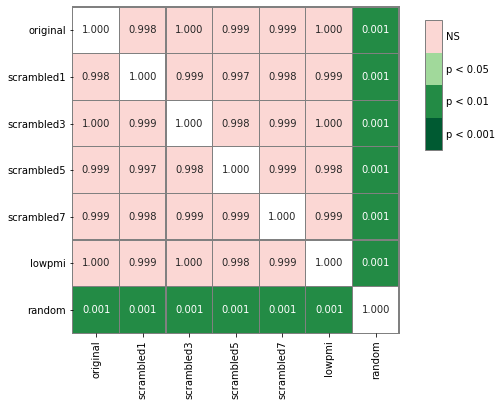

In [144]:
g=anova_ttest('glove')

['projection']
skipping backward
projection
projection
projection
projection
projection
projection
projection
            lowpmi  original  random  scrambled1  scrambled3  scrambled5  \
lowpmi        -1.0       0.0     2.0         0.0         0.0         0.0   
original       0.0      -1.0     2.0         0.0         0.0         0.0   
random         2.0       2.0    -1.0         2.0         2.0         2.0   
scrambled1     0.0       0.0     2.0        -1.0         0.0         0.0   
scrambled3     0.0       0.0     2.0         0.0        -1.0         0.0   
scrambled5     0.0       0.0     2.0         0.0         0.0        -1.0   
scrambled7     0.0       0.0     2.0         0.0         0.0         0.0   

            scrambled7  
lowpmi             0.0  
original           0.0  
random             2.0  
scrambled1         0.0  
scrambled3         0.0  
scrambled5         0.0  
scrambled7        -1.0  
-----------


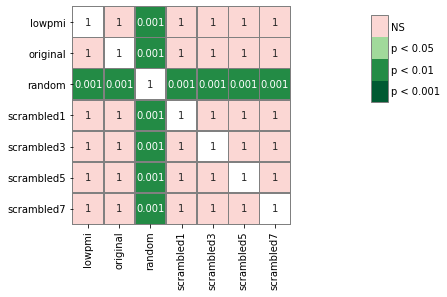

In [115]:
g=anova_ttest_plot('glove')

In [111]:
g

(<matplotlib.axes._subplots.AxesSubplot at 0x2aeb69c04be0>,
 <matplotlib.colorbar.ColorbarBase at 0x2aeb69dfcfd0>)

## LM1B

In [108]:
get_all_layers('lm_1b')

['lstm/lstm_0/control_dependency', 'lstm/lstm_1/control_dependency']

['lstm/lstm_0/control_dependency', 'lstm/lstm_1/control_dependency']
skipping backward
lstm/lstm_1/control_dependency
lstm/lstm_1/control_dependency
lstm/lstm_1/control_dependency
lstm/lstm_1/control_dependency
lstm/lstm_1/control_dependency
lstm/lstm_1/control_dependency
lstm/lstm_1/control_dependency
ANOVA F-statistic and p-value: (11.74124638744173, 8.64627860173705e-09)
            lowpmi  original  random  scrambled1  scrambled3  scrambled5  \
lowpmi        -1.0       3.0     1.0         3.0         0.0         0.0   
original       3.0      -1.0     1.0         0.0         0.0         0.0   
random         1.0       1.0    -1.0         1.0         1.0         1.0   
scrambled1     3.0       0.0     1.0        -1.0         0.0         0.0   
scrambled3     0.0       0.0     1.0         0.0        -1.0         0.0   
scrambled5     0.0       0.0     1.0         0.0         0.0        -1.0   
scrambled7     0.0       0.0     1.0         0.0         0.0         0.0   

            sc

,lowpmi,original,random,scrambled1,scrambled3,scrambled5,scrambled7
lowpmi,1.000000,0.019866,0.000614,0.019995,0.080509,0.144374,0.259347
original,0.019866,1.000000,0.000006,0.805826,0.448636,0.336200,0.123105
random,0.000614,0.000006,1.000000,0.000003,0.000017,0.000042,0.000038
scrambled1,0.019995,0.805826,0.000003,1.000000,0.561947,0.417949,0.144954
scrambled3,0.080509,0.448636,0.000017,0.561947,1.000000,0.804794,0.419141
scrambled5,0.144374,0.336200,0.000042,0.417949,0.804794,1.000000,0.608664
scrambled7,0.259347,0.123105,0.000038,0.144954,0.419141,0.608664,1.000000


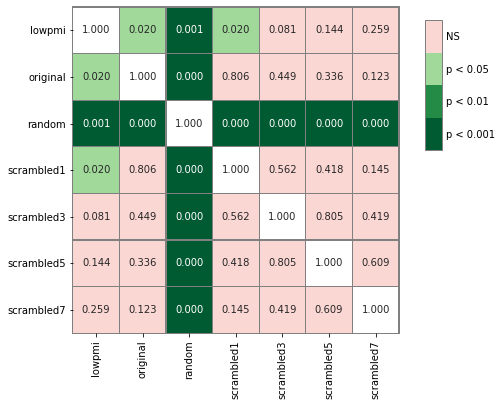

In [109]:
anova_ttest('lm_1b')

## Skip

['encoder']
encoder
encoder
encoder
encoder
encoder
encoder
encoder
ANOVA F-statistic and p-value: (12.439191435822698, 3.436464943947066e-09)
            lowpmi  original  random  scrambled1  scrambled3  scrambled5  \
lowpmi        -1.0       0.0     1.0         0.0         0.0         0.0   
original       0.0      -1.0     1.0         0.0         0.0         0.0   
random         1.0       1.0    -1.0         1.0         1.0         1.0   
scrambled1     0.0       0.0     1.0        -1.0         0.0         0.0   
scrambled3     0.0       0.0     1.0         0.0        -1.0         0.0   
scrambled5     0.0       0.0     1.0         0.0         0.0        -1.0   
scrambled7     0.0       0.0     1.0         0.0         0.0         0.0   

            scrambled7  
lowpmi             0.0  
original           0.0  
random             1.0  
scrambled1         0.0  
scrambled3         0.0  
scrambled5         0.0  
scrambled7        -1.0  
-----------


,lowpmi,original,random,scrambled1,scrambled3,scrambled5,scrambled7
lowpmi,1.000000e+00,4.500252e-01,1.918241e-07,0.857722,9.002576e-01,0.890063,0.428349
original,4.500252e-01,1.000000e+00,6.147688e-07,0.606585,5.275584e-01,0.601919,0.172233
random,1.918241e-07,6.147688e-07,1.000000e+00,0.000002,2.748168e-07,0.000004,0.000004
scrambled1,8.577222e-01,6.065848e-01,1.667219e-06,1.000000,9.463457e-01,0.977470,0.394578
scrambled3,9.002576e-01,5.275584e-01,2.748168e-07,0.946346,1.000000e+00,0.973625,0.378858
scrambled5,8.900630e-01,6.019192e-01,3.838420e-06,0.977470,9.736247e-01,1.000000,0.433726
scrambled7,4.283490e-01,1.722333e-01,3.546371e-06,0.394578,3.788582e-01,0.433726,1.000000


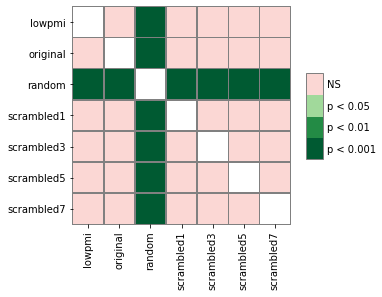

In [29]:
anova_ttest('skip-thoughts')

## Albert XXL

['embeddings', 'encoder.albert_layer_groups.0', 'encoder.albert_layer_groups.1', 'encoder.albert_layer_groups.2', 'encoder.albert_layer_groups.3', 'encoder.albert_layer_groups.4', 'encoder.albert_layer_groups.5', 'encoder.albert_layer_groups.6', 'encoder.albert_layer_groups.7', 'encoder.albert_layer_groups.8', 'encoder.albert_layer_groups.9', 'encoder.albert_layer_groups.10', 'encoder.albert_layer_groups.11']
skipping backward
encoder.albert_layer_groups.11
encoder.albert_layer_groups.11
encoder.albert_layer_groups.11
encoder.albert_layer_groups.11
encoder.albert_layer_groups.11
encoder.albert_layer_groups.11
encoder.albert_layer_groups.11
ANOVA F-statistic and p-value: (2.26853984561801, 0.04798125702228956)
            lowpmi  original  random  scrambled1  scrambled3  scrambled5  \
lowpmi        -1.0       0.0     2.0         3.0         3.0         0.0   
original       0.0      -1.0     0.0         0.0         0.0         0.0   
random         2.0       0.0    -1.0         0.0     

,lowpmi,original,random,scrambled1,scrambled3,scrambled5,scrambled7
lowpmi,1.000000,0.265449,0.008527,0.029147,0.037282,0.087209,0.230785
original,0.265449,1.000000,0.115260,0.358513,0.320407,0.634123,0.864530
random,0.008527,0.115260,1.000000,0.310553,0.540323,0.176488,0.029667
scrambled1,0.029147,0.358513,0.310553,1.000000,0.795324,0.604440,0.131526
scrambled3,0.037282,0.320407,0.540323,0.795324,1.000000,0.511795,0.156240
scrambled5,0.087209,0.634123,0.176488,0.604440,0.511795,1.000000,0.400538
scrambled7,0.230785,0.864530,0.029667,0.131526,0.156240,0.400538,1.000000


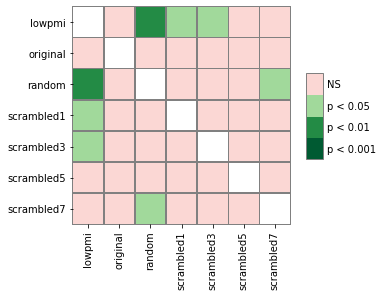

In [30]:
anova_ttest('albert-xxlarge-v2')

## BERT 

['embedding', 'encoder.layer.0.output', 'encoder.layer.1.output', 'encoder.layer.2.output', 'encoder.layer.3.output', 'encoder.layer.4.output', 'encoder.layer.5.output', 'encoder.layer.6.output', 'encoder.layer.7.output', 'encoder.layer.8.output', 'encoder.layer.9.output', 'encoder.layer.10.output', 'encoder.layer.11.output', 'encoder.layer.12.output', 'encoder.layer.13.output', 'encoder.layer.14.output', 'encoder.layer.15.output', 'encoder.layer.16.output', 'encoder.layer.17.output', 'encoder.layer.18.output', 'encoder.layer.19.output', 'encoder.layer.20.output', 'encoder.layer.21.output', 'encoder.layer.22.output', 'encoder.layer.23.output']
skipping backward
encoder.layer.23.output
encoder.layer.23.output
encoder.layer.23.output
encoder.layer.23.output
encoder.layer.23.output
encoder.layer.23.output
encoder.layer.23.output
ANOVA F-statistic and p-value: (2.185784399043644, 0.05596333640196834)
            lowpmi  original  random  scrambled1  scrambled3  scrambled5  \
lowpmi        

,lowpmi,original,random,scrambled1,scrambled3,scrambled5,scrambled7
lowpmi,1.000000,0.515640,0.005431,0.454677,0.723378,0.180517,0.196124
original,0.515640,1.000000,0.019515,0.952045,0.757488,0.485607,0.486464
random,0.005431,0.019515,1.000000,0.014060,0.009705,0.055755,0.092590
scrambled1,0.454677,0.952045,0.014060,1.000000,0.696622,0.489401,0.492952
scrambled3,0.723378,0.757488,0.009705,0.696622,1.000000,0.308299,0.321403
scrambled5,0.180517,0.485607,0.055755,0.489401,0.308299,1.000000,0.950625
scrambled7,0.196124,0.486464,0.092590,0.492952,0.321403,0.950625,1.000000


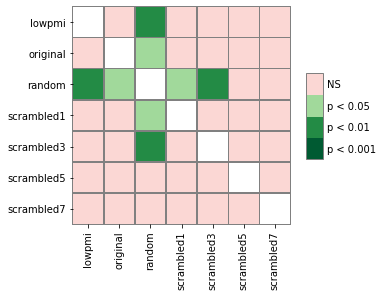

In [31]:
anova_ttest('bert-large-uncased-whole-word-masking')

## XLNET

['drop', 'encoder.layer.0', 'encoder.layer.1', 'encoder.layer.2', 'encoder.layer.3', 'encoder.layer.4', 'encoder.layer.5', 'encoder.layer.6', 'encoder.layer.7', 'encoder.layer.8', 'encoder.layer.9', 'encoder.layer.10', 'encoder.layer.11', 'encoder.layer.12', 'encoder.layer.13', 'encoder.layer.14', 'encoder.layer.15', 'encoder.layer.16', 'encoder.layer.17', 'encoder.layer.18', 'encoder.layer.19', 'encoder.layer.20', 'encoder.layer.21', 'encoder.layer.22', 'encoder.layer.23']
skipping backward
encoder.layer.23
encoder.layer.23
encoder.layer.23
encoder.layer.23
encoder.layer.23
encoder.layer.23
encoder.layer.23
ANOVA F-statistic and p-value: (2.7910296666421925, 0.01799646868236881)
            lowpmi  original  random  scrambled1  scrambled3  scrambled5  \
lowpmi        -1.0       0.0     2.0         0.0         0.0         0.0   
original       0.0      -1.0     1.0         0.0         0.0         0.0   
random         2.0       1.0    -1.0         0.0         1.0         2.0   
scrambl

,lowpmi,original,random,scrambled1,scrambled3,scrambled5,scrambled7
lowpmi,1.000000,0.276361,0.007473,0.472990,0.376123,0.491468,0.804327
original,0.276361,1.000000,0.000299,0.105324,0.762325,0.758302,0.474392
random,0.007473,0.000299,1.000000,0.132432,0.000193,0.002827,0.012228
scrambled1,0.472990,0.105324,0.132432,1.000000,0.139501,0.209224,0.386798
scrambled3,0.376123,0.762325,0.000193,0.139501,1.000000,0.952663,0.614576
scrambled5,0.491468,0.758302,0.002827,0.209224,0.952663,1.000000,0.696888
scrambled7,0.804327,0.474392,0.012228,0.386798,0.614576,0.696888,1.000000


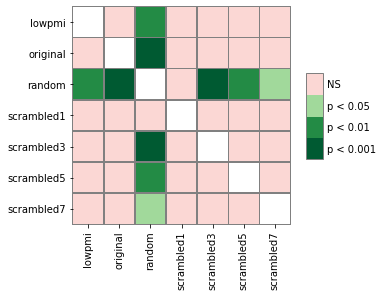

In [32]:
anova_ttest('xlnet-large-cased')

## DistilGPT

['drop', 'encoder.h.0', 'encoder.h.1', 'encoder.h.2', 'encoder.h.3', 'encoder.h.4', 'encoder.h.5']
skipping backward
encoder.h.5
encoder.h.5
encoder.h.5
encoder.h.5
encoder.h.5
encoder.h.5
encoder.h.5
ANOVA F-statistic and p-value: (1.8989655136813994, 0.09484214660811449)
            lowpmi  original  random  scrambled1  scrambled3  scrambled5  \
lowpmi        -1.0       0.0     1.0         0.0         0.0         0.0   
original       0.0      -1.0     3.0         0.0         0.0         0.0   
random         1.0       3.0    -1.0         0.0         3.0         3.0   
scrambled1     0.0       0.0     0.0        -1.0         0.0         0.0   
scrambled3     0.0       0.0     3.0         0.0        -1.0         0.0   
scrambled5     0.0       0.0     3.0         0.0         0.0        -1.0   
scrambled7     0.0       0.0     3.0         0.0         0.0         0.0   

            scrambled7  
lowpmi             0.0  
original           0.0  
random             3.0  
scrambled1       

,lowpmi,original,random,scrambled1,scrambled3,scrambled5,scrambled7
lowpmi,1.000000,0.082251,0.000127,0.235951,0.087621,0.258246,0.373301
original,0.082251,1.000000,0.044453,0.835898,0.799783,0.712198,0.604537
random,0.000127,0.044453,1.000000,0.071166,0.011445,0.036530,0.032950
scrambled1,0.235951,0.835898,0.071166,1.000000,0.984374,0.899683,0.789328
scrambled3,0.087621,0.799783,0.011445,0.984374,1.000000,0.856693,0.725963
scrambled5,0.258246,0.712198,0.036530,0.899683,0.856693,1.000000,0.877652
scrambled7,0.373301,0.604537,0.032950,0.789328,0.725963,0.877652,1.000000


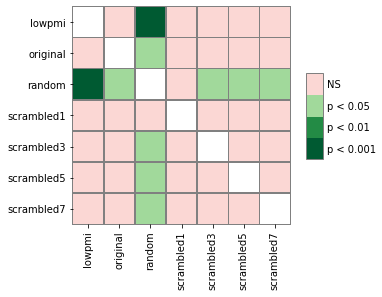

In [33]:
anova_ttest('distilgpt2')

## GPT2

['drop', 'encoder.h.0', 'encoder.h.1', 'encoder.h.2', 'encoder.h.3', 'encoder.h.4', 'encoder.h.5', 'encoder.h.6', 'encoder.h.7', 'encoder.h.8', 'encoder.h.9', 'encoder.h.10', 'encoder.h.11']
skipping backward
encoder.h.11
encoder.h.11
encoder.h.11
encoder.h.11
encoder.h.11
encoder.h.11
encoder.h.11
ANOVA F-statistic and p-value: (3.609639337192375, 0.003861095304522321)
            lowpmi  original  random  scrambled1  scrambled3  scrambled5  \
lowpmi        -1.0       0.0     1.0         0.0         0.0         0.0   
original       0.0      -1.0     2.0         0.0         0.0         0.0   
random         1.0       2.0    -1.0         2.0         2.0         3.0   
scrambled1     0.0       0.0     2.0        -1.0         0.0         0.0   
scrambled3     0.0       0.0     2.0         0.0        -1.0         0.0   
scrambled5     0.0       0.0     3.0         0.0         0.0        -1.0   
scrambled7     0.0       0.0     2.0         0.0         0.0         0.0   

            scramb

,lowpmi,original,random,scrambled1,scrambled3,scrambled5,scrambled7
lowpmi,1.000000,0.405174,0.000192,0.587859,0.654164,0.160224,0.999671
original,0.405174,1.000000,0.006877,0.824821,0.784680,0.647779,0.486143
random,0.000192,0.006877,1.000000,0.004873,0.005368,0.015902,0.001170
scrambled1,0.587859,0.824821,0.004873,1.000000,0.953941,0.502748,0.647592
scrambled3,0.654164,0.784680,0.005368,0.953941,1.000000,0.479207,0.702045
scrambled5,0.160224,0.647779,0.015902,0.502748,0.479207,1.000000,0.243143
scrambled7,0.999671,0.486143,0.001170,0.647592,0.702045,0.243143,1.000000


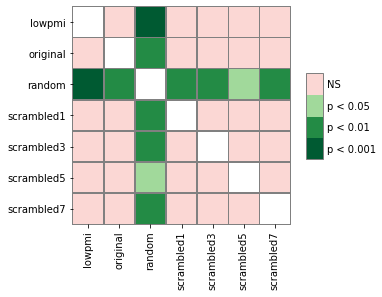

In [27]:
anova_ttest('gpt2')

# tests etc.

In [20]:
layers = np.unique(r.layer)
final_layer = layers[-1]
final_layer

'encoder.h.5'

In [23]:
raw_scores = r.raw.raw

In [35]:
r.raw

<xarray.Score (layer: 7, aggregation: 2)>
array([[0.005476, 0.007933],
       [0.086211, 0.014237],
       [0.092361, 0.019187],
       [0.117364, 0.012359],
       [0.123416, 0.039974],
       [0.154493, 0.036411],
       [0.19886 , 0.037256]])
Coordinates:
  * layer        (layer) object 'drop' 'encoder.h.0' ... 'encoder.h.5'
  * aggregation  (aggregation) <U6 'center' 'error'
Attributes:
    raw:          <xarray.Score (layer: 7, neuroid: 13517)>\narray([[-0.02184...
    description:  score aggregated by taking median of neuroids per subject, ...

In [33]:
r.raw.raw

<xarray.Score (layer: 7, neuroid: 13517)>
array([[-0.021846, -0.009141, -0.039724, ...,  0.047193,  0.045555,  0.041627],
       [ 0.172304,  0.116457,  0.116495, ...,  0.054278,  0.086306,  0.157817],
       [ 0.216855,  0.214871,  0.159111, ..., -0.015549,  0.024096,  0.168122],
       ...,
       [ 0.19957 ,  0.122417,  0.185846, ...,  0.005716,  0.05131 ,  0.143815],
       [ 0.265723,  0.217845,  0.234662, ...,  0.052576,  0.095097,  0.163468],
       [ 0.342637,  0.295614,  0.288781, ...,  0.160883,  0.183349,  0.212766]])
Coordinates:
  * layer            (layer) object 'drop' 'encoder.h.0' ... 'encoder.h.5'
  * neuroid          (neuroid) MultiIndex
  - subject          (neuroid) object '018' '018' '018' ... '018' '018' '018'
  - voxel_num        (neuroid) int64 28 29 31 32 38 42 ... 152 153 154 159 160
  - filter_strategy  (neuroid) object '' '' '' '' '' '' '' ... '' '' '' '' '' ''
  - atlas_selection  (neuroid) object 'from90to100prcnt' ... 'from90to100prcnt'
  - roi          

In [34]:
r.ceiling 

<xarray.Score (aggregation: 3)>
array([0.318567, 0.012958, 0.016574])
Coordinates:
  * aggregation  (aggregation) object 'center' 'error_low' 'error_high'
Attributes:
    class_module:  brainscore.metrics
    class_name:    Score

In [43]:
def getCenter2(obj):
    x = obj[{'aggregation': [agg == 'center' for agg in obj['aggregation'].values]}].squeeze('aggregation')
    return x

In [46]:
center_ceil = getCenter2(r.ceiling)

In [41]:
final_layer_raw = raw_scores[{"layer": [layer == final_layer for layer in raw_scores["layer"]]}]

In [42]:
final_layer_raw.groupby('subject').median().median()

/om/user/gretatu/.conda/envs/brainmodeling/lib/python3.6/site-packages/xarray/core/groupby.py:639: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)


<xarray.Score ()>
array(0.19886)

In [47]:
final_layer_raw.groupby('subject').median().median() / center_ceil # checks out

<xarray.Score ()>
array(0.624232)
Coordinates:
    aggregation  <U6 'center'

In [48]:
r

<xarray.Score (layer: 7, aggregation: 2)>
array([[0.017189, 0.024903],
       [0.27062 , 0.04469 ],
       [0.289925, 0.060229],
       [0.368413, 0.038795],
       [0.387411, 0.125482],
       [0.484961, 0.114296],
       [0.624232, 0.116947]])
Coordinates:
  * layer        (layer) object 'drop' 'encoder.h.0' ... 'encoder.h.5'
  * aggregation  (aggregation) <U6 'center' 'error'
Attributes:
    raw:          <xarray.Score (layer: 7, aggregation: 2)>\narray([[0.005476...
    ceiling:      <xarray.Score (aggregation: 3)>\narray([0.318567, 0.012958,...
    description:  ceiling-normalized score
    model:        distilgpt2
    benchmark:    Pereira2018-encoding-scrambled-backward

In [6]:
scores_df = get_last_scores_df('distilgpt2')

### Quick sanity check

In [7]:
scores_df

,score,error,condition
2,0.445486,0.141692,original
4,0.433109,0.152545,scrambled1
5,0.433109,0.152545,scrambled1
6,0.481103,0.092081,scrambled3
7,0.509842,0.204048,scrambled5
8,0.422906,0.156049,scrambled7
1,0.525676,0.094445,lowpmi
0,0.624232,0.116947,backward
3,0.356489,0.025445,random


In [9]:
def bar_plot(model_identifier,get_last_scores_df):
    colors = sns.color_palette("rocket")
    x_pos = np.arange(len(get_last_scores_df))
    scores = get_last_scores_df['score']
    errors = get_last_scores_df['error']
    conditions = get_last_scores_df['condition']
    fig, ax = plt.subplots()
    ax.bar(x_pos, scores,
       yerr=errors,
       align='center',
       alpha=0.8, #color intensity
       ecolor='black',
       capsize=5, #error bar width
       color=colors[1]) #if you put just color=colors, you get the bar plots in different rocket palette colors
    ax.set_ylabel('ceiled score',fontsize=12)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(conditions, rotation=60)
    ax.set_title('{}'.format(model_identifier),fontsize=18)
    ax.yaxis.grid(True)

In [10]:
def main_plot(model_identifier):
    scores_df = get_last_scores_df(model_identifier)
    bar_plot(model_identifier,scores_df)

# Ready to plot!

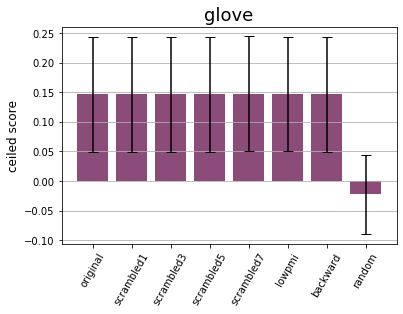

In [11]:
main_plot('glove')

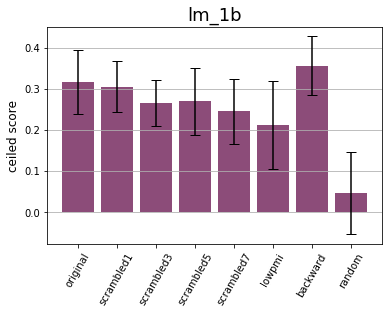

In [12]:
main_plot('lm_1b')

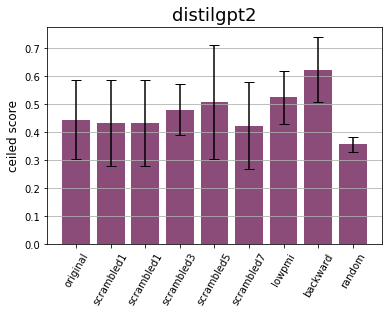

In [13]:
main_plot('distilgpt2')

# Loop to create subplots

In [197]:
import math
from matplotlib.gridspec import GridSpec

def get_subplots_loop(model_list):
    nsubplots = len(model_list)
    nrows = math.ceil(nsubplots/2)
    colors = sns.color_palette("rocket")
    
    fig2 = plt.figure(constrained_layout=True, figsize=(15, 7))
    fig2.suptitle('Last-layer score across scrambling conditions', fontsize=22, y=1.05)
    spec2 = GridSpec(ncols=2, nrows=nrows, figure=fig2)
    f2_ax = []
    
    counter = 0
    for i in range(nrows):
        for j in range(2):
            if counter + 1 > nsubplots:
                break
            else:
                scores_df = get_last_scores_df(model_list[counter])
                x_pos = np.arange(len(scores_df))
                scores = scores_df['score']
                errors = scores_df['error']
                conditions = scores_df['condition']

                f2_ax.append(fig2.add_subplot(spec2[i, j]))
                f2_ax[-1].bar(x_pos, scores,
                       yerr=errors,
                       align='center',
                       alpha=0.8, #color intensity
                       ecolor='black',
                       capsize=5, #error bar width
                       color=colors[1]) #if you put just color=colors, you get the bar plots in different rocket palette colors
                f2_ax[-1].set_ylabel('ceiled score',fontsize=12)
                f2_ax[-1].set_xticks(x_pos)
                f2_ax[-1].set_xticklabels(conditions, rotation=60)
                f2_ax[-1].set_title('{}'.format(model_list[counter]),fontsize=18)
                f2_ax[-1].yaxis.grid(True)
                counter += 1

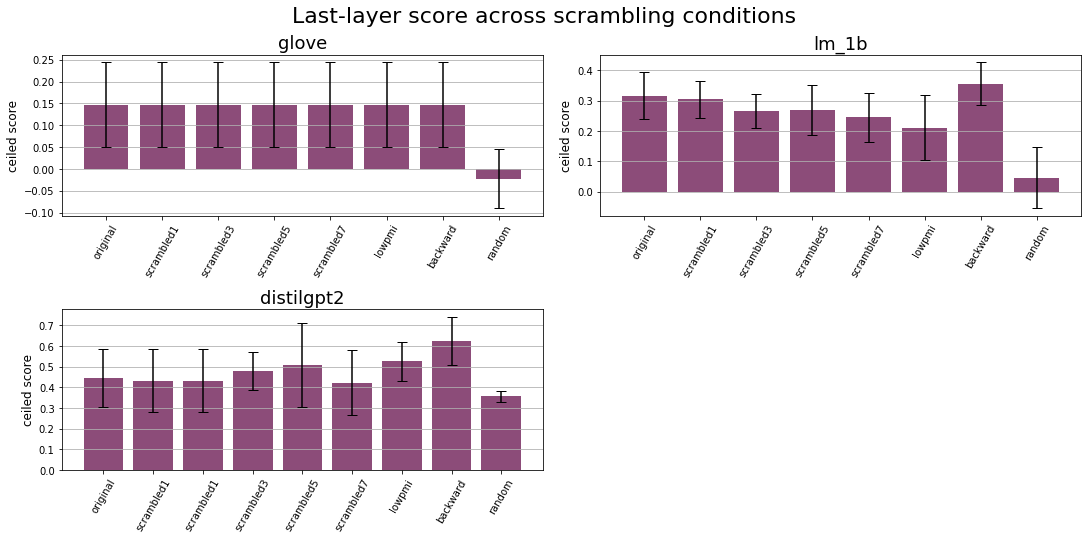

In [198]:
get_subplots_loop(['glove','lm_1b','distilgpt2'])

_____________________________
_____________________________
# Lineplot over layers

In [170]:
def get_score_dict(model_identifier):
    """
    input: model_identifier
    output: dictionary containing the maximum score and associated error per condition.
            structure of dictionary: condition --> {score --> list of scores across layers,
                                                    error --> list of associated errors}
    """
    score_dict = {}
    for filename in os.listdir(working_dir):
        model_name = filename.split(",")[1]
        if "model=" + model_identifier == model_name:
            condition = filename.split(",")[0].split("Pereira2018-encoding-")[-1]
            if "-" in condition:
                condition = condition.split("-")[1]
            #print(condition)
            if not condition in score_dict:
                score_dict[condition] = {}
            file = os.path.join(working_dir,filename)
            with open(file, 'rb') as f:
                out = pickle.load(f)
            result = out['data'].values
            scores = [result[i][0] for i in range(len(result))]
            errors = [result[i][1] for i in range(len(result))]
            score_dict[condition]['score'] = scores
            score_dict[condition]['error'] = errors
    ordered_score_dict = reorder_df(score_dict)
    return ordered_score_dict

In [171]:
def reorder_df(dictionary):
    desired_order_list = ['original', 'scrambled1', 'scrambled3', 'scrambled5', 'scrambled7', 'lowpmi', 'backward', 'random']
    reordered_dict = {k: dictionary[k] for k in desired_order_list}
    return reordered_dict

In [172]:
distilgpt2_score_dict = get_score_dict('distilgpt2')

In [173]:
print(distilgpt2_score_dict.keys())

dict_keys(['original', 'scrambled1', 'scrambled3', 'scrambled5', 'scrambled7', 'lowpmi', 'backward', 'random'])


In [174]:
print(distilgpt2_score_dict['scrambled7'])

{'score': [0.005539049489326797, 0.14970464170619252, 0.237560435165642, 0.21334449646321693, 0.22330666668304588, 0.3339344479134766, 0.4229061986841613], 'error': [0.04257054092245925, 0.06127134659096494, 0.10616068467862835, 0.09501375209872086, 0.16333758189676043, 0.08780399225569428, 0.156048807773573]}


In [175]:
working_dir2 = "/om2/user/ckauf/.result_caching/neural_nlp.models.wrapper.core.ActivationsExtractorHelper._from_sentences_stored"
def get_all_layers(model_identifier):
    """
    input: model_identifier of model of which we want to find the layers
    output: np.array of all unique layer identifiers, ordered by position
    """
    for ind,filename in enumerate(os.listdir(working_dir2)):
        if "identifier=" + model_identifier in filename:
            file = os.path.join(working_dir2,filename)
            with open(file, 'rb') as f:
                result = pickle.load(f)
            result = result['data']
            layers = np.unique(result.layer)
            if model_identifier == 'lm_1b':
                layers = [layer.split('/')[1] for layer in layers]
            return layers
            break

In [176]:
get_all_layers('lm_1b')

['lstm_0', 'lstm_1']

In [177]:
def get_layerplot(model_identifier):
    line_colors = sns.color_palette("rocket") + sns.color_palette("GnBu_d")
    layers = get_all_layers(model_identifier)
    score_dict = get_score_dict(model_identifier)
    fig, ax = plt.subplots()
    
    x = np.array(layers)
    counter = 0
    for key,value in score_dict.items():
        ax.plot(x,np.array(score_dict[key]['score']), '-o',color=line_colors[counter])
        counter += 1

    conditions = list(distilgpt2_score_dict.keys())

    ax.set_title('Layer neural score evolution across conditions')
    ax.legend(conditions)
    ax.yaxis.set_label_text('ceiled score')
    plt.xticks(rotation= 90)

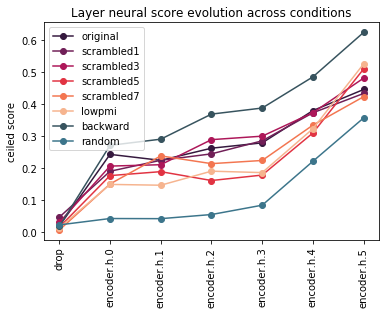

In [178]:
get_layerplot('distilgpt2')

## Loop models into subplots

In [225]:
import math
from matplotlib.gridspec import GridSpec

def get_lineplots_loop(model_list,error_shading=False):
    nsubplots = len(model_list)
    nrows = math.ceil(nsubplots/2)
    line_colors = sns.color_palette("rocket") + [sns.color_palette("PRGn", 10)[2]] + [sns.color_palette("PuOr", 10)[0]]
    
    fig2 = plt.figure(constrained_layout=True, figsize=(15, 5*nrows))
    fig2.suptitle('Score evolution of layers over scrambling conditions', fontsize=22, y=1.05)
    spec2 = GridSpec(ncols=2, nrows=nrows, figure=fig2)
    f2_ax = []
    
    model_counter = 0
    for i in range(nrows):
        for j in range(2):
            if model_counter + 1 > nsubplots:
                break
            else:
                layers = get_all_layers(model_list[model_counter])
                score_dict = get_score_dict(model_list[model_counter])
                f2_ax.append(fig2.add_subplot(spec2[i, j]))
                
                counter = 0
                x = np.array(layers)
                for key,value in score_dict.items():
                    f2_ax[-1].plot(x,np.array(score_dict[key]['score']), '-o',color=line_colors[counter])
                    if error_shading==True:
                        f2_ax[-1].fill_between(x,np.array(score_dict[key]['score'])-np.array(score_dict[key]['error']), np.array(score_dict[key]['score'])+np.array(score_dict[key]['error']),facecolor=line_colors[counter],alpha=0.5)
                    counter += 1

                conditions = list(distilgpt2_score_dict.keys())

                f2_ax[-1].set_title('{}'.format(model_list[model_counter]),fontsize=18)
                f2_ax[-1].yaxis.set_label_text('ceiled score')
                plt.xticks(rotation= 90)
                model_counter += 1
    fig2.legend(conditions, loc='lower right')

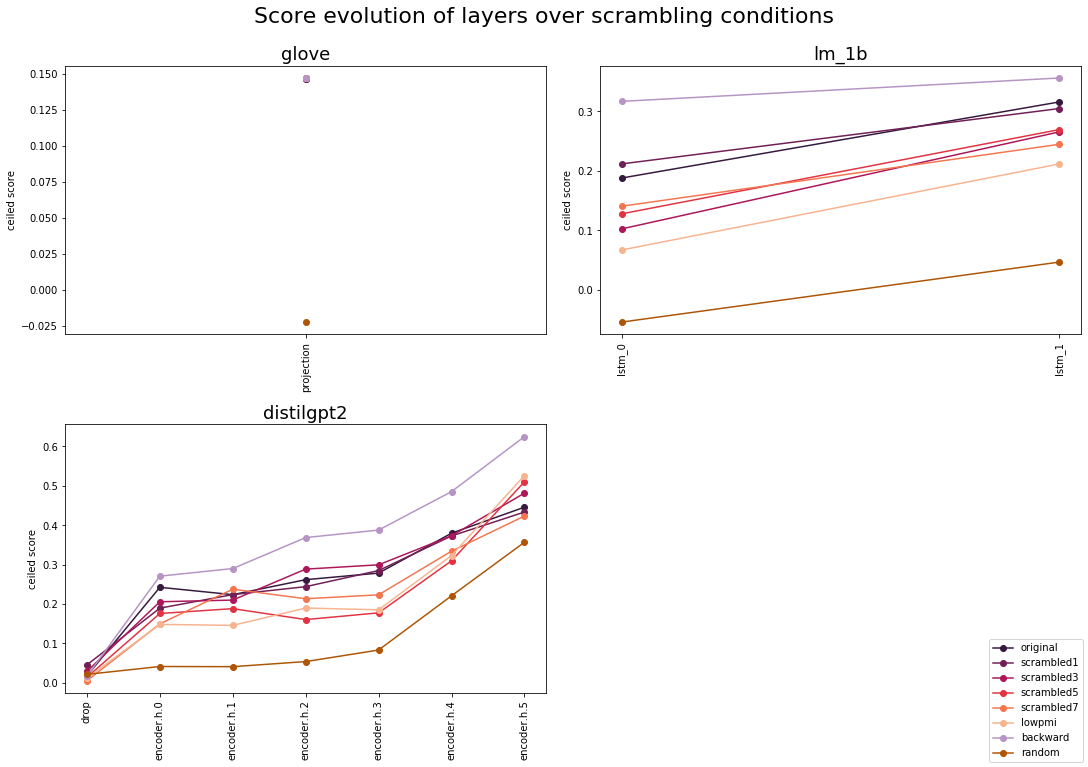

In [226]:
get_lineplots_loop(['glove','lm_1b','distilgpt2'])

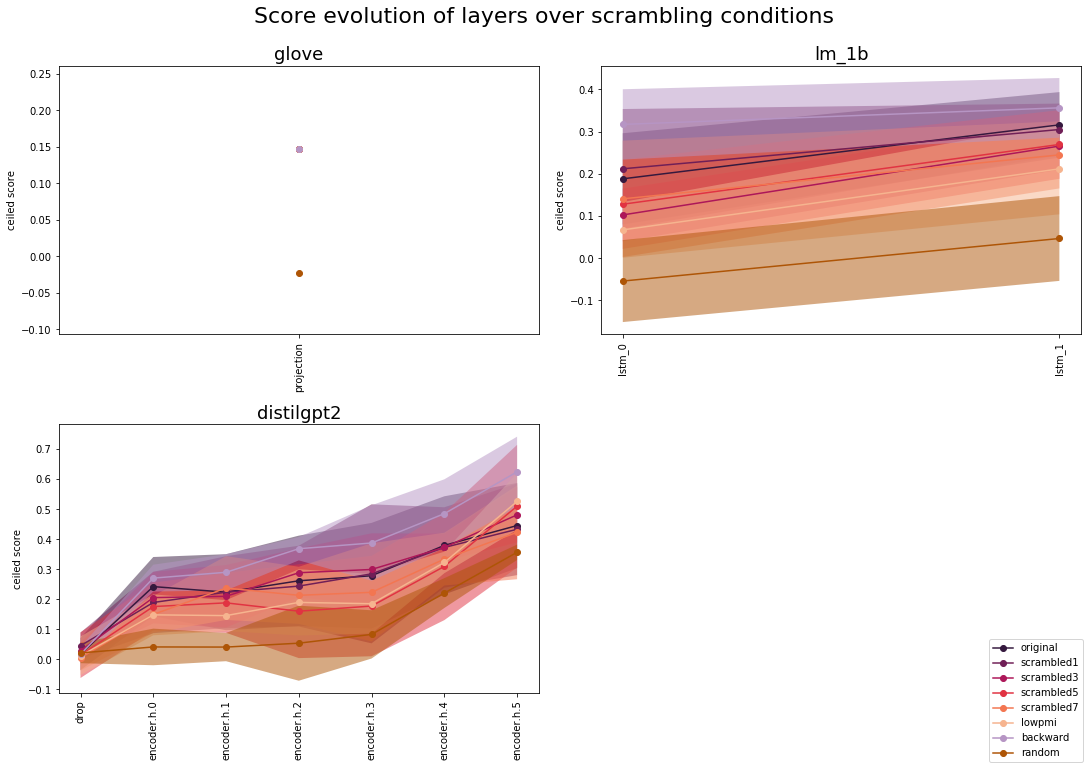

In [227]:
get_lineplots_loop(['glove','lm_1b','distilgpt2'],error_shading=True)